# Postprocessing for BOMEX LES
### Smagorinsky model with Kessler microphysics dx = dy = 100 m and dz = 40 m

In [42]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from windtools.plotting import plot_profile
from erftools.postprocessing import AveragedProfiles
from erftools.constants import R_d, R_v, Cp_d, p_0, L_v
from erftools.EOS import getPgivenRTh, getRhogivenThetaPress
import glob
import os

## Formatting and save figures option

In [50]:
save_fig = False

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# Presentations
plt.rcParams.update({
    "text.usetex": True,
    "figure.figsize": (10,10),
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "font.weight": "bold",
    "lines.linewidth": 2,
    "lines.markeredgewidth": 2.0, 
    "lines.markersize": 16,
    "axes.titlesize": 26,
    "axes.labelsize": 26,
    "axes.linewidth": 2.0,
    "xtick.major.width": 2.0,
    "xtick.minor.width": 1.0,
    "xtick.major.size": 4.0,
    "xtick.minor.size": 2.0,
    "xtick.direction": "in",
    "ytick.major.width": 2.0,
    "ytick.minor.width":1.0,
    "ytick.major.size": 4.0,
    "ytick.minor.size": 2.0,
    "ytick.direction": "in",
    "legend.fontsize": 16,
})

## Precomputed terms

In [44]:
psurf   = 101500. # [Pa]
thsurf  = 298.7 # [K]
qvsurf  = 0.01729 # water vapor mixing ratio # [kg/kg]
rhosurf = getRhogivenThetaPress(thsurf, psurf, qv=qvsurf)

inp_ustar = 0.28
inp_hfx   = 8e-3 # [K-m/s]
inp_lfx   = 5.2e-5 # latent heat flux [m/s]
dz = 40.

last3h = slice(21600 - 3*3600,None)
last1h = slice(21600 -   3600,None)

fedir  ='./datasets'
indir  = './BOMEX-Kessler'
outdir = '.'

# output of:
#   grep '^Cloud fraction' log | awk '{print $3, $4}' > cloud_fraction.txt
cloud_frac_hist = f'{indir}/cloud_fraction.txt'

# load data
avg = AveragedProfiles([f'{indir}/mean', f'{indir}/flux', f'{indir}/subgrid'])

cloud_frac = pd.read_csv(f'{indir}/cloud_fraction.txt',
                         delim_whitespace=True,names=['t','cloud_fraction']).set_index('t')
cloud_frac = cloud_frac.set_index(pd.to_timedelta(cloud_frac.index,unit='s'))
cloud_frac = cloud_frac.resample('6s',label='right').interpolate()

# setup fields for Kessler (no rain)
avg.ds['ql'] = avg['qc'] #+ avg['qr']
avg.ds['qt'] = avg['qv'] + avg['ql']
assert np.all(avg['qi'] == 0)
assert np.all(avg['qs'] == 0)
assert np.all(avg['qg'] == 0)
avg.ds["w'ql'"] = avg["w'qc'"] #+ avg["w'qr'"]
avg.ds["w'qt'"] = avg["w'qv'"] + avg["w'ql'"]
avg.ds['θv'] = avg['θ'] * (1 + 0.61*avg['qv'] - avg['ql'])

# TKE, vertically integrated
avg.ds['k'] = 0.5 * (avg.ds["u'u'"] + avg.ds["v'v'"] + avg.ds["w'w'"])
integ_k = (avg['ρ']*avg['k']).sum('z') * dz
integ_k.name = 'vertically integrated TKE'

# liquid water path
LWP = (1000*avg['ρ']*avg.ds['ql']).sum('z') * dz
LWP.name = 'liquid water path'

# exner pressure
rhotheta = avg['ρ'] * avg['θ']
p = getPgivenRTh(rhotheta, qv=avg['qv'])
avg.ds['Π'] = (p / p_0)**(R_d/Cp_d)

# liquid-water potential temperature flux
avg.ds["θl'w'"] = avg["θ'w'"] - 1/avg['Π']*L_v/Cp_d*avg["w'ql'"]

Loading mean profiles from ./BOMEX-Kessler/mean
Loading resolved flux profiles from ./BOMEX-Kessler/flux
Loading SFS stress profiles from ./BOMEX-Kessler/subgrid


## Plot time series for cloud cover, LWP, and TKE

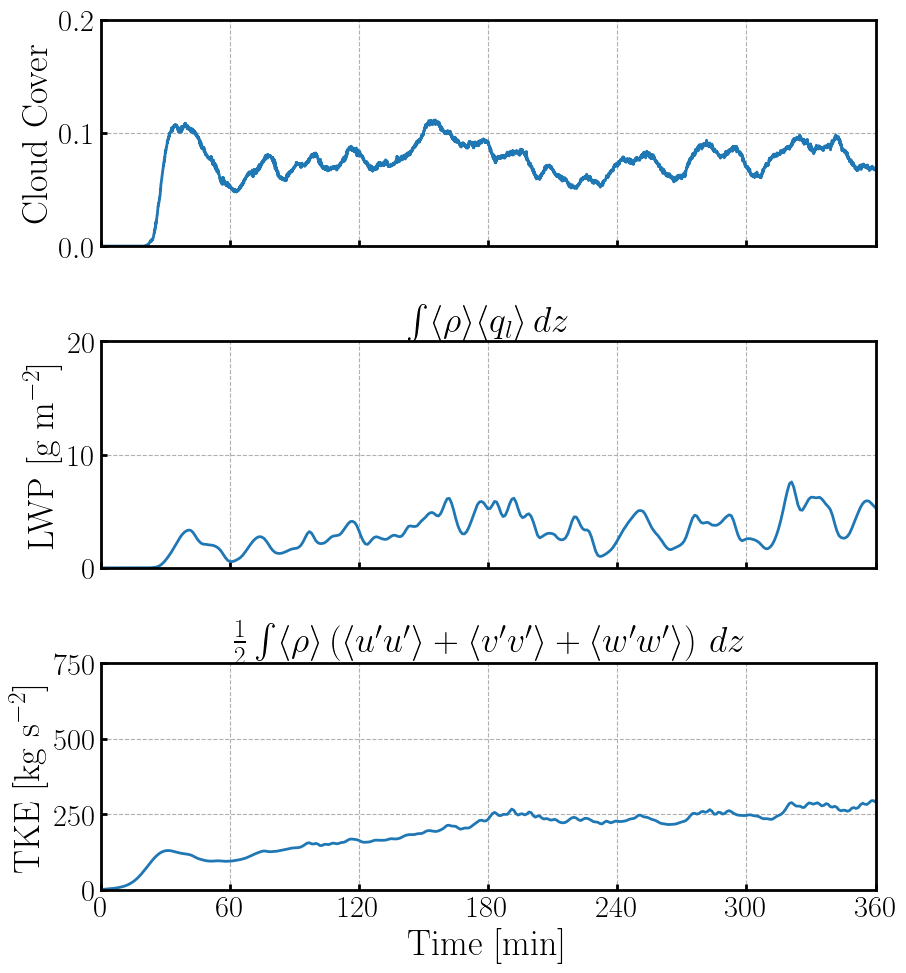

In [45]:
time = np.array(cloud_frac.index/np.timedelta64(60,'s'))
fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(10,10))
minutes = np.array(avg['t'] / 60.)
axs[0].set_ylim((0,0.2))
axs[0].plot(time, cloud_frac['cloud_fraction'].values)
axs[0].set_ylabel('Cloud Cover')

axs[1].plot(minutes, LWP)
axs[1].set_ylabel('LWP [g m$^{-2}$]')
axs[1].set_title(r"$\int \langle\rho\rangle \langle q_l\rangle \,dz$")
axs[1].set_ylim((0,20))

axs[2].plot(minutes, integ_k)
axs[2].set_ylabel('TKE [kg s$^{-2}$]')
axs[2].set_xlabel('Time [min]')
axs[2].set_title(r"$\frac{1}{2} \int \langle\rho\rangle \left(\langle u'u'\rangle + \langle v'v'\rangle + \langle w'w'\rangle \right) \,dz$")
axs[2].set_ylim((0,750))
axs[2].set_yticks([0,250,500,750])

axs[-1].set_xlim((0,360))
axs[-1].set_xticks(np.arange(0,361,60))
for ax in axs:
    ax.grid(linestyle='--',alpha=1.0)

# Shift the top subplots
for i in range(3):
    pos = axs[i].get_position()
    new_pos = [pos.x0, pos.y0+0.09-float(i)*0.05, pos.width, pos.height]
    axs[i].set_position(new_pos)

if (save_fig):
    fpath = f'{outdir}/BOMEX_time_series.png'
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

## Plot planar and temporally averaged fields

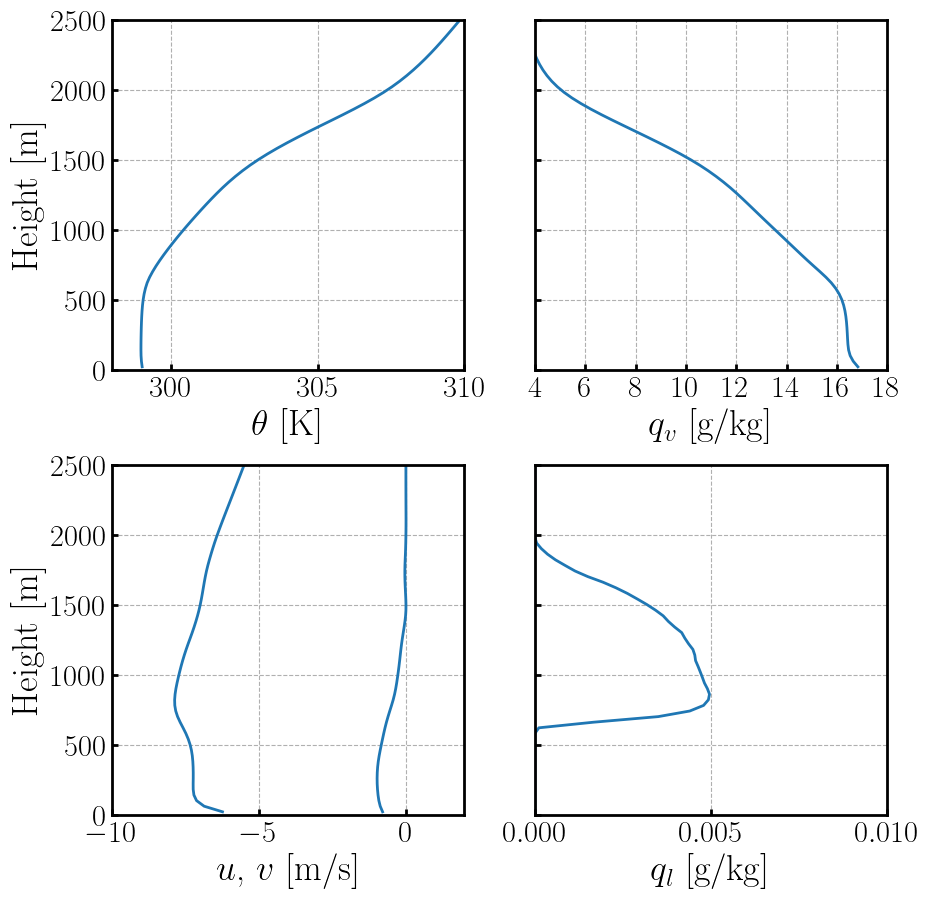

In [46]:
plotvars = ['θ','qv','u','v','ql']
plotme = avg.ds[plotvars].sel(t=last1h).mean('t')
plotme['qv'] *= 1000
plotme['ql'] *= 1000

fig,axs4 = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(10,10))
axs = [[axs4[0,0], axs4[0,1], axs4[1,0], axs4[1,0], axs4[1,1]]]

plot_profile(plotme, fields=plotvars,
             heightlimits=(0,2500),
             cmap='viridis',
             fig=fig,ax=axs)

axs4[0,0].set_xlabel(r'$\theta$ [K]')
axs4[0,0].set_xlim((298,310))
axs4[0,0].set_ylabel('Height [m]')
axs4[0,1].set_xlabel(r'$q_v$ [g/kg]')
axs4[0,1].set_xlim((4,18))
axs4[0,1].set_xticks(np.arange(4,19,2))
axs4[1,0].set_ylabel('Height [m]')
axs4[1,0].set_xlabel(r'$u$, $v$ [m/s]')
axs4[1,0].set_xlim((-10,2))
axs4[1,1].set_xlabel(r'$q_l$ [g/kg]')
axs4[1,1].set_xlim((0,0.01))

# Shift the top subplots
for i in range(2):
    pos = axs4[0, i].get_position()
    new_pos = [pos.x0, pos.y0+0.025, pos.width, pos.height]
    axs4[0, i].set_position(new_pos)

for ax in axs:
    for i in range(np.size(ax)):
        ax[i].set_yticks(np.arange(0,2501,500))
        ax[i].grid(linestyle='--',alpha=1.0)

if (save_fig):
    fpath = f'{outdir}/BOMEX_mean_profiles.png'
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

## Plot planar and temporally averaged turbulent fluxes

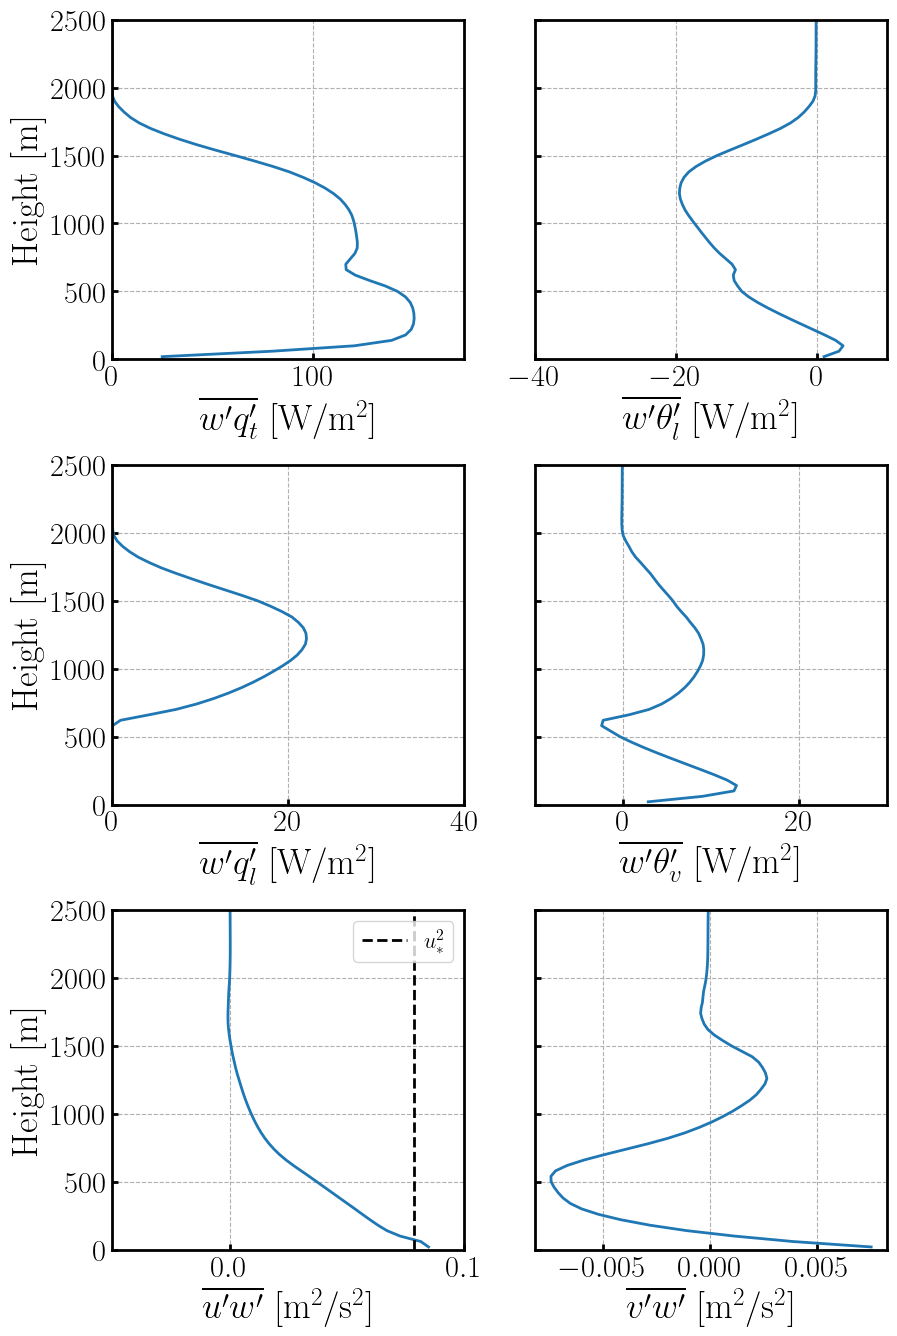

In [47]:
plotme = xr.Dataset()
plotvars = ["w'qt'","θl'w'","w'ql'","θv'w'","u'w'","v'w'"]
plotme["θl'w'"] = avg["ρ"] * Cp_d * (avg["θl'w'"]) # no SFS
plotme["θv'w'"] = avg["ρ"] * Cp_d * (avg["θv'w'"]) # no SFS
plotme["w'qt'"] = avg["ρ"] * L_v  * avg["w'qt'"]
plotme["w'ql'"] = avg["ρ"] * L_v  * avg["w'ql'"]
plotme["u'w'"]  = avg["u'w'"] + avg["τ13"]
plotme["v'w'"]  = avg["v'w'"] + avg["τ23"]
plotme = plotme.sel(t=last3h).mean('t')

fig,axs = plt.subplots(nrows=3,ncols=2,sharey=True,figsize=(10,15))

plot_profile(plotme, fields=plotvars,
             heightlimits=(0,2500),
             cmap='viridis',
             #labelsubplots=True,
             fig=fig,ax=axs)

axs[0,0].set_xlabel(r"$\overline{w'q_t'}$ [W/m$^2$]")
axs[0,0].set_xlim((0,175))
axs[0,1].set_xlabel(r"$\overline{w'\theta_l'}$ [W/m$^2$]")
axs[0,1].set_xlim((-40,10))
axs[1,0].set_xlabel(r"$\overline{w'q_l'}$ [W/m$^2$]")
axs[1,0].set_xlim((0,40))
axs[1,1].set_xlabel(r"$\overline{w'\theta_v'}$ [W/m$^2$]")
axs[1,1].set_xlim((-10,30))
axs[2,0].set_xlabel(r"$\overline{u'w'}$ [m$^2$/s$^2$]")
axs[2,0].set_xlim((-.05,.1))
axs[2,1].set_xlabel(r"$\overline{v'w'}$ [m$^2$/s$^2$]")

line = axs[2,0].axvline(inp_ustar**2,ls='--',c='k')
axs[2,0].legend([line], ['$u_*^2$'], loc='upper right')

for ax in axs:
    for i in range(np.size(ax)):
        ax[i].set_yticks(np.arange(0,2501,500))
        ax[i].grid(linestyle='--',alpha=1.0)

for i in range(2):
    pos = axs[0, i].get_position()
    new_pos = [pos.x0, pos.y0+0.05, pos.width, pos.height]
    axs[0, i].set_position(new_pos)
    pos = axs[1, i].get_position()
    new_pos = [pos.x0, pos.y0+0.025, pos.width, pos.height]
    axs[1, i].set_position(new_pos)

if (save_fig):
    fpath = f'{outdir}/BOMEX_flux_profiles.png'
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

## Plot planar and temporally averaged TKE and vertical velocity variance

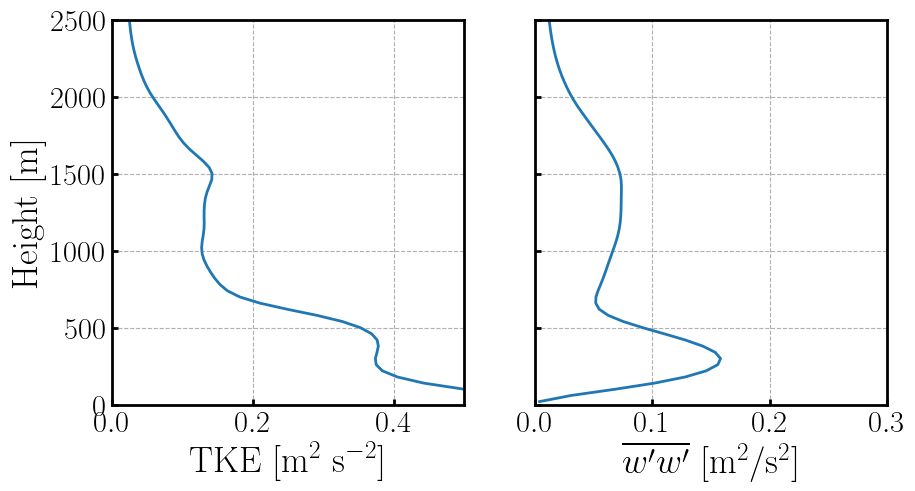

In [48]:
plotme = avg[["w'w'"]].copy()
plotme['tke'] = (avg["u'u'"] + avg["v'v'"] + avg["w'w'"])
plotme = plotme.sel(t=last3h).mean('t')

fig,axs = plt.subplots(ncols=2,sharey=True,figsize=(10,5))
_,_ = plot_profile(plotme, fields=["tke","w'w'"],
                   heightlimits=(0,2500),
                   cmap='viridis',
                   fig=fig,ax=axs)
axs[0].set_xlabel(r'TKE [m$^2$ s$^{-2}$]')
axs[0].set_xlim((0,0.5))
axs[1].set_xlabel(r"$\overline{w'w'}$ [m$^2$/s$^2$]")
axs[1].set_xlim((0,0.3))

for ax in axs:
    ax.set_yticks(np.arange(0,2501,500))
    ax.grid(linestyle='--',alpha=1.0)

if (save_fig):
    fpath = f'{outdir}/BOMEX_vel_var_profiles.png'
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

## FastEddy comparison (turbulent fluxes)

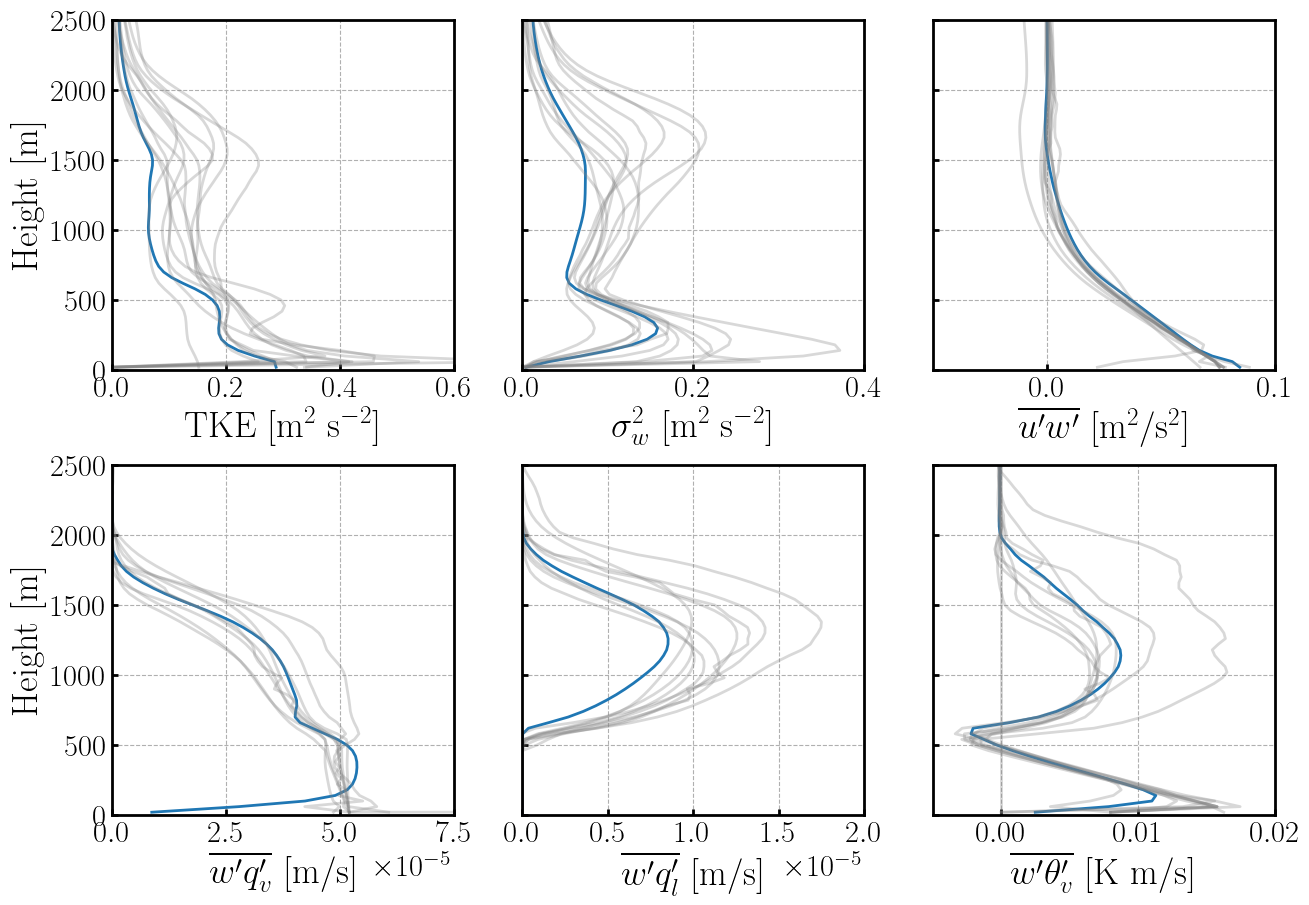

In [49]:
avg.ds['ql'] = avg['qc'] #+ avg['qr']
avg.ds['qt'] = avg['qv'] + avg['ql']
assert np.all(avg['qi'] == 0)
assert np.all(avg['qs'] == 0)
assert np.all(avg['qg'] == 0)
avg.ds["w'ql'"] = avg["w'qc'"] #+ avg["w'qr'"]
avg.ds["w'qt'"] = avg["w'qv'"] + avg["w'ql'"]

# additional calcs
Tmax = avg.ds['t'].values[-1]
last3h = slice(Tmax-3*3600,None)

avg.ds['tke'] = 0.5 * (avg.ds["u'u'"] + avg.ds["v'v'"] + avg.ds["w'w'"])
avg.ds['uw_covar']  = avg["u'w'"] + avg["τ13"]


# make plot
plotvars = ["tke","w'w'","uw_covar","w'qv'","w'ql'","θv'w'"]
plotme = avg.ds[plotvars].sel(t=last3h).mean('t')

fig,axs = plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(15,10))

plot_profile(plotme, fields=plotvars,
             heightlimits=(0,2500),
             cmap='viridis',
             #labelsubplots=True,
             fig=fig,ax=axs)

axs[0,0].set_xlabel(r'TKE [m$^2$ s$^{-2}$]')
axs[0,0].set_xlim((0,0.6))
axs[0,1].set_xlabel(r'$\sigma_{w}^2$ [m$^2$ s$^{-2}$]')
axs[0,1].set_xlim((0,0.4))
axs[0,2].set_xlabel(r"$\overline{u'w'}$ [m$^2$/s$^2$]")
axs[0,2].set_xlim((-.05,.1))
axs[1,0].set_xlabel(r"$\overline{w'q_v'}$ [m/s]")
axs[1,0].set_xlim((0,7.5e-5))
axs[1,1].set_xlabel(r"$\overline{w'q_l'}$ [m/s]")
axs[1,1].set_xlim((0,2e-5))
axs[1,1].set_xticks(np.linspace(0.0, 2e-5, num=5))
axs[1,2].set_xlabel(r"$\overline{w'\theta_v'}$ [K m/s]")
axs[1,2].set_xlim((-0.5e-2,2e-2))

for ax in axs:
    for i in range(np.size(ax)):
        ax[i].set_yticks(np.arange(0,2501,500))
        ax[i].grid(linestyle='--',alpha=1.0)

# Shift the top subplots
for i in range(3):
    pos = axs[0, i].get_position()
    new_pos = [pos.x0, pos.y0+0.025, pos.width, pos.height]
    axs[0, i].set_position(new_pos)


# Reference datasets
siebdata = glob.glob(fedir + '/*.nc')
siebmodels = [os.path.split(fpath)[1][:-3] for fpath in siebdata]
sieb = {name: xr.open_dataset(fpath).isel(time=slice(-3,None)).mean('time')
        for name,fpath in zip(siebmodels,siebdata)}

siebstyle = dict(lw=2,c='0.5',alpha=0.3)
for model,ref in sieb.items():
    if model==list(sieb.keys())[0]:
        siebstyle['label'] = 'Siebesma et al. 2003'
    else:
        siebstyle['label'] = None
    axs[0,0].plot(0.5*(ref['UU']+ref['ww']), ref['zA'], **siebstyle)
    axs[0,1].plot(ref['ww'], ref['zA'], **siebstyle)
    axs[0,2].plot(ref['uw']*1e-2, ref['zA'], **siebstyle)
    axs[1,0].plot((ref['wqt']-ref['wql'])*1e-5, ref['zA'], **siebstyle)
    axs[1,1].plot(ref['wql']*1e-5, ref['zA'], **siebstyle)
    axs[1,2].plot(ref['wthv']*1e-2, ref['zA'], **siebstyle)

if (save_fig):
    fpath = f'{outdir}/BOMEX_flux_comp_profiles.png'
    fig.savefig(fpath, dpi=300, bbox_inches='tight')